In [ ]:
!pip -q install shap

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
CSV_PATH = "/content/drive/MyDrive/24204379_AndrianaYong_WQF7009_XAI_AA/kidney_dataset.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Cannot find '{CSV_PATH}'. Check your Drive path and filename.")

df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nHead:\n", df.head())

Shape: (5000, 11)

Columns: ['Creatinine', 'BUN', 'GFR', 'Urine_Output', 'Diabetes', 'Hypertension', 'Age', 'Protein_in_Urine', 'Water_Intake', 'Medication', 'CKD_Status']

Head:
    Creatinine        BUN         GFR  Urine_Output  Diabetes  Hypertension  \
0    0.788803   8.386869  102.161787   1632.649387         0             0   
1    3.413970  53.688796   50.071257    935.540516         1             0   
2    0.647645   7.466540   89.451831   1774.553846         1             1   
3    0.795508  12.516821   99.872180   2360.602980         0             0   
4    0.869010  19.855960   86.110182   1987.750901         0             1   

         Age  Protein_in_Urine  Water_Intake     Medication  CKD_Status  
0  27.682074        106.700203      1.570370            NaN           0  
1  33.122208        410.008362      3.425287  ACE Inhibitor           1  
2  55.832284        123.336925      1.123301       Diuretic           0  
3  32.391900        116.098870      3.086846  ACE Inhib

In [14]:
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution (CKD_Status):\n", df["CKD_Status"].value_counts(normalize=True))



Missing values:
 Creatinine             0
BUN                    0
GFR                    0
Urine_Output           0
Diabetes               0
Hypertension           0
Age                    0
Protein_in_Urine       0
Water_Intake           0
Medication          2987
CKD_Status             0
dtype: int64

Target distribution (CKD_Status):
 CKD_Status
0    0.737
1    0.263
Name: proportion, dtype: float64


In [15]:
TARGET = "CKD_Status"

In [16]:
DROP_COLS = ["GFR"] if "GFR" in df.columns else []

X = df.drop(columns=[TARGET] + DROP_COLS)
y = df[TARGET].astype(int)

categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("\nCategorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


Categorical columns: ['Medication']
Numeric columns: ['Creatinine', 'BUN', 'Urine_Output', 'Diabetes', 'Hypertension', 'Age', 'Protein_in_Urine', 'Water_Intake']


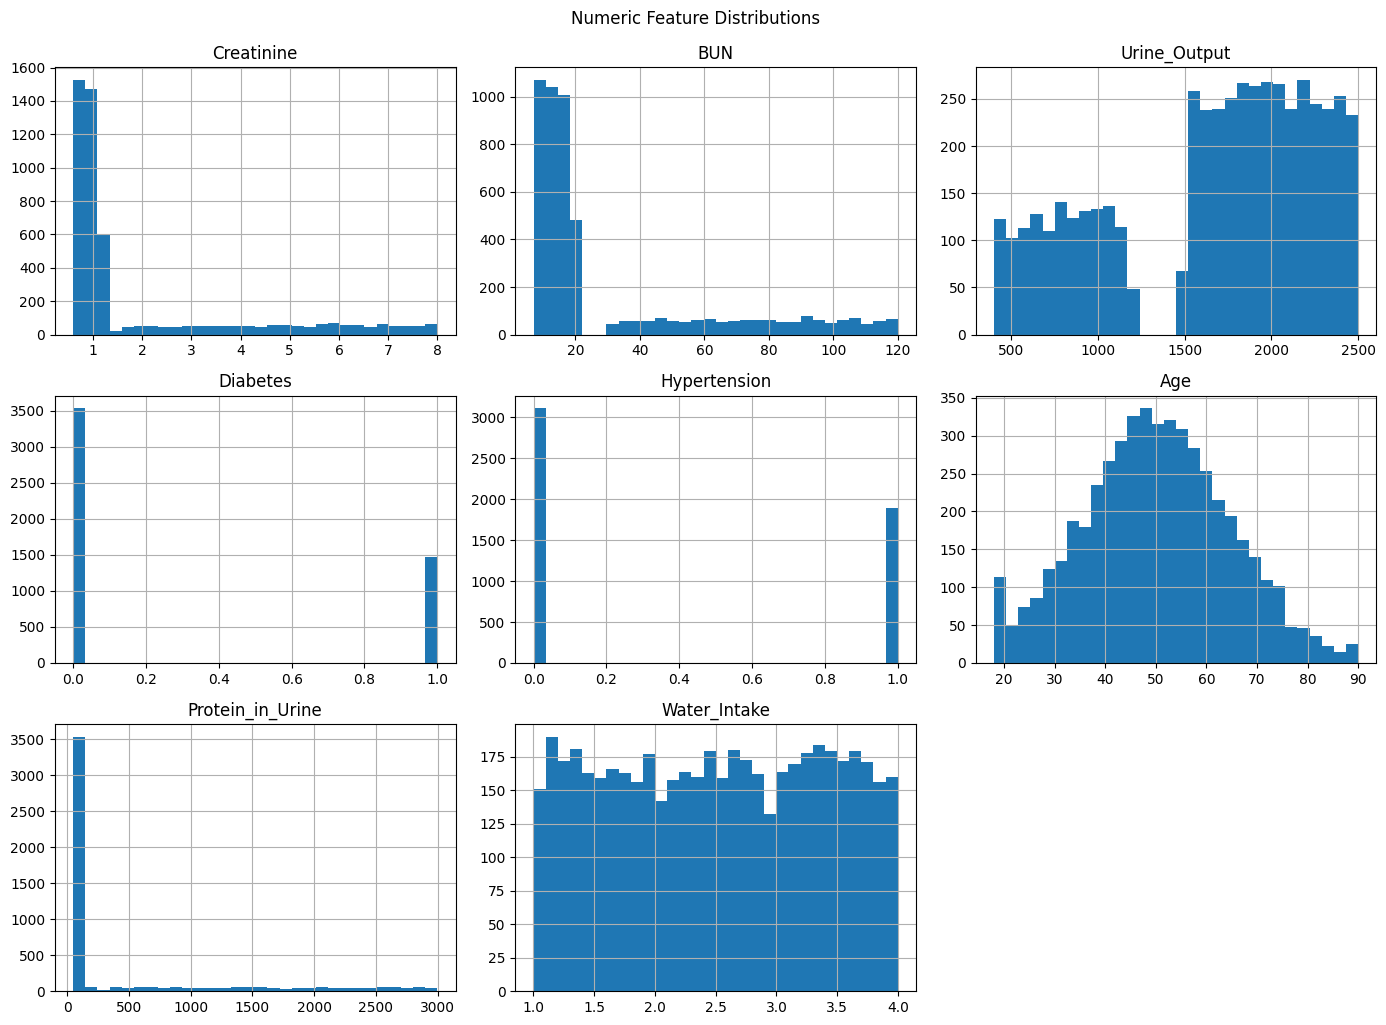

In [17]:
X[numeric_cols].hist(bins=30, figsize=(14, 10))
plt.tight_layout()
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()

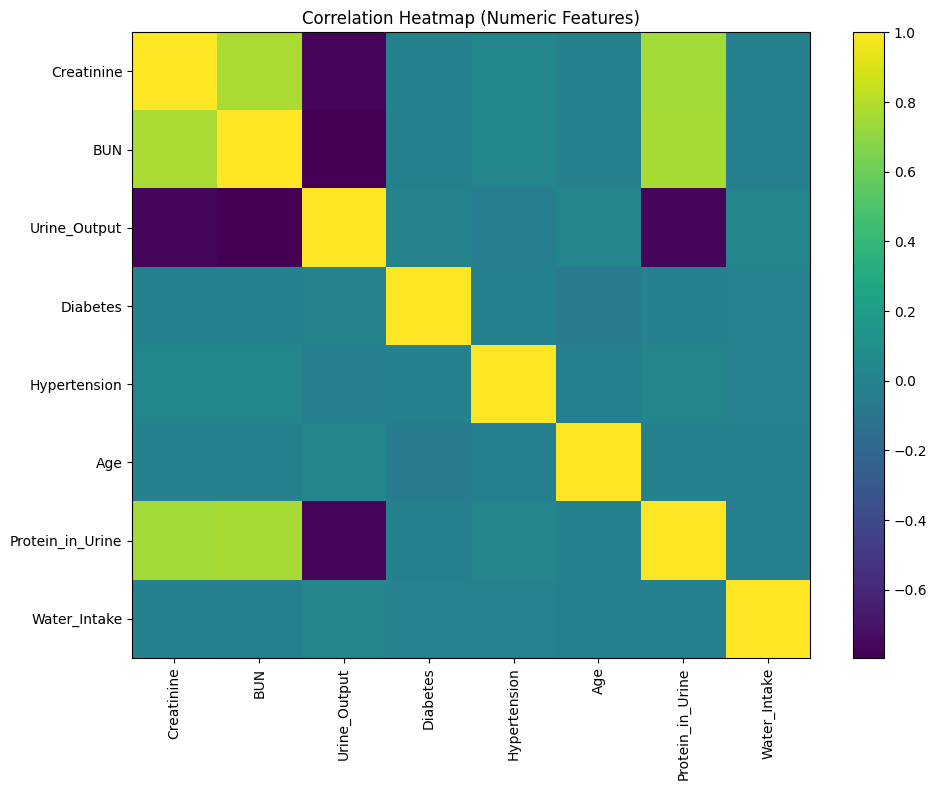

In [18]:
corr = X[numeric_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

In [19]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop"
)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Medication']),
                                                 ('num', 'passthrough',
                                                  ['Creatinine', 'BUN',
                                                   'Urine_Output', 'Diabetes',
                                                   'Hypertension', 'Age',
                                                   'Protein_in_Urine',
                                                   'Water_Intake'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])


=== Model Performance (Test Set) ===
Accuracy : 0.9960
Precision: 0.9850
Recall   : 1.0000
F1-score : 0.9925
ROC-AUC  : 0.9998


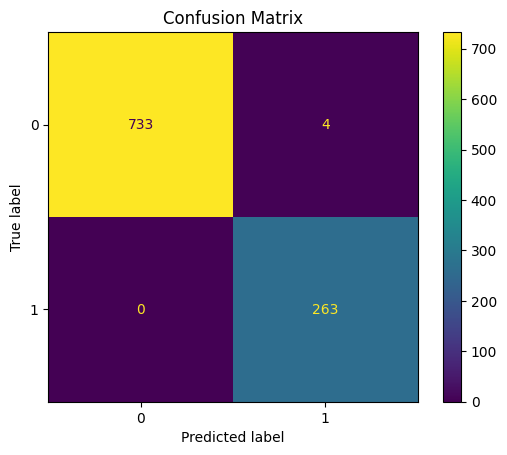

In [20]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Model Performance (Test Set) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

X_trans shape: (500, 12)
len(feature_names): 12
Aligned lengths used = 12 | mean_abs_shap len = 12 | feature_names len = 12

Top 15 features by mean(|SHAP|):
                     feature  importance
4                 Creatinine    0.194641
5                        BUN    0.127100
10          Protein_in_Urine    0.097390
6               Urine_Output    0.071120
9                        Age    0.003551
7                   Diabetes    0.002922
11              Water_Intake    0.002187
8               Hypertension    0.002176
2        Medication_Diuretic    0.000436
0   Medication_ACE Inhibitor    0.000426
3             Medication_nan    0.000415
1             Medication_ARB    0.000359


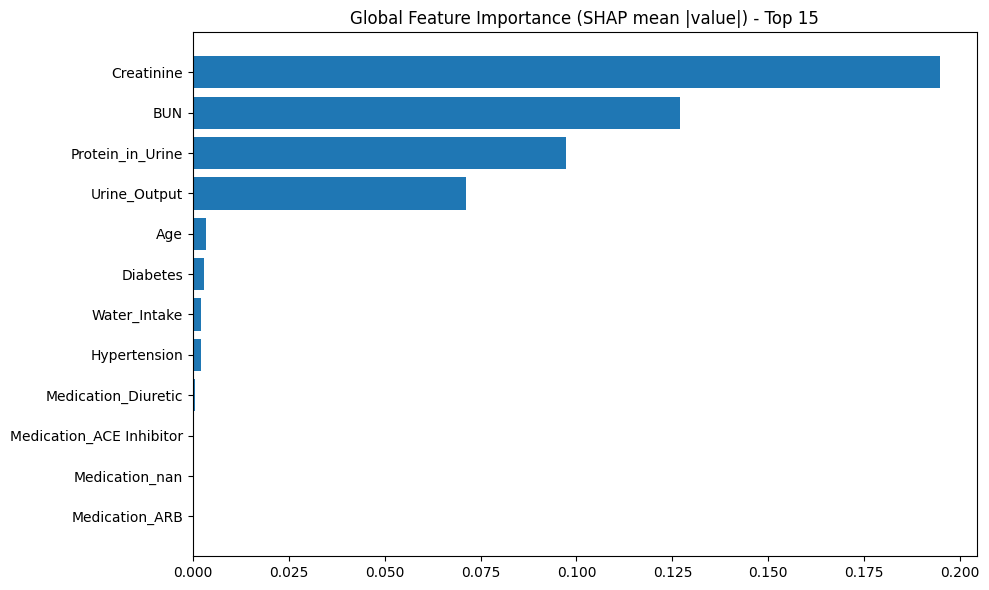

/tmp/ipython-input-4196265799.py:71: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_mat[:, :m], X_trans[:, :m], feature_names=feature_names, show=True)


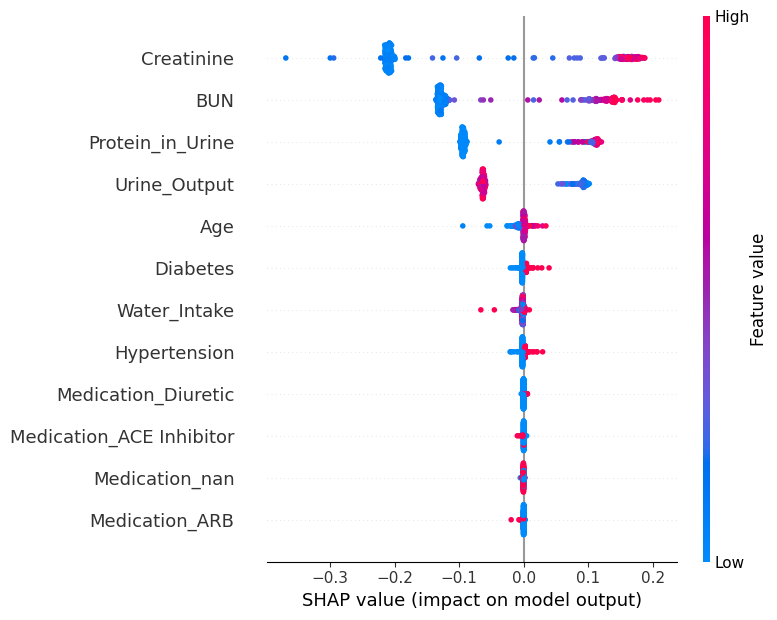

In [21]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

def get_feature_names(preprocess, categorical_cols, numeric_cols):
    try:
        feature_names = list(preprocess.get_feature_names_out())
    except Exception:
        feature_names = []
        if len(categorical_cols) > 0:
            ohe = preprocess.named_transformers_["cat"]
            feature_names += list(ohe.get_feature_names_out(categorical_cols))
        feature_names += list(numeric_cols)

    feature_names = [f.replace("cat__", "").replace("num__", "") for f in feature_names]
    return feature_names

pre = model.named_steps["preprocess"]
X_test_sample = X_test.sample(
    n=min(500, len(X_test)),
    random_state=42
)

X_trans = pre.transform(X_test_sample)

feature_names = get_feature_names(pre, categorical_cols, numeric_cols)

print("X_trans shape:", X_trans.shape)
print("len(feature_names):", len(feature_names))

explainer = shap.TreeExplainer(model.named_steps["rf"])
shap_values = explainer.shap_values(X_trans)

# Handle SHAP outputs:
# list: one array per class
# 3D array: (n_samples, n_features, n_classes)
# 2D array: (n_samples, n_features)
if isinstance(shap_values, list):
    shap_mat = shap_values[1]  # positive class (CKD=1)
else:
    shap_arr = np.array(shap_values)
    if shap_arr.ndim == 3:
        shap_mat = shap_arr[:, :, 1]  # positive class
    else:
        shap_mat = shap_arr

mean_abs_shap = np.mean(np.abs(shap_mat), axis=0)

m = min(len(feature_names), len(mean_abs_shap), X_trans.shape[1])
feature_names = feature_names[:m]
mean_abs_shap = mean_abs_shap[:m]

print("Aligned lengths used =", m, "| mean_abs_shap len =", len(mean_abs_shap), "| feature_names len =", len(feature_names))

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_abs_shap
}).sort_values("importance", ascending=False)

print("\nTop 15 features by mean(|SHAP|):")
print(imp_df.head(15))

plt.figure(figsize=(10, 6))
plt.barh(imp_df["feature"].head(15)[::-1], imp_df["importance"].head(15)[::-1])
plt.title("Global Feature Importance (SHAP mean |value|) - Top 15")
plt.tight_layout()
plt.show()

try:
    shap.summary_plot(shap_mat[:, :m], X_trans[:, :m], feature_names=feature_names, show=True)
except Exception as e:
    print("SHAP summary_plot skipped due to:", e)


=== Counterfactual Target Instance ===
Index: 2733
Original predicted label (1=CKD): 1 | CKD probability: 0.9825

Original instance:
       Creatinine        BUN  Urine_Output  Diabetes  Hypertension        Age  \
2733    5.538431  83.401889   1120.785363         1             1  27.071131   

      Protein_in_Urine  Water_Intake Medication  
2733       2780.539065      2.456626        ARB  

=== Counterfactual Found (Constrained) ===
Meta: {'restart': 0, 'iters': 3, 'orig_label': 1, 'orig_proba': np.float64(0.9825), 'cf_proba': np.float64(0.4425)}
Counterfactual predicted label: 0 | CKD probability: 0.4425

Original vs Counterfactual:
    Original_Creatinine  Original_BUN  Original_Urine_Output  \
0             5.538431     83.401889            1120.785363   

   Original_Diabetes  Original_Hypertension  Original_Age  \
0                  1                      1     27.071131   

   Original_Protein_in_Urine  Original_Water_Intake Original_Medication  \
0                2780.539065 

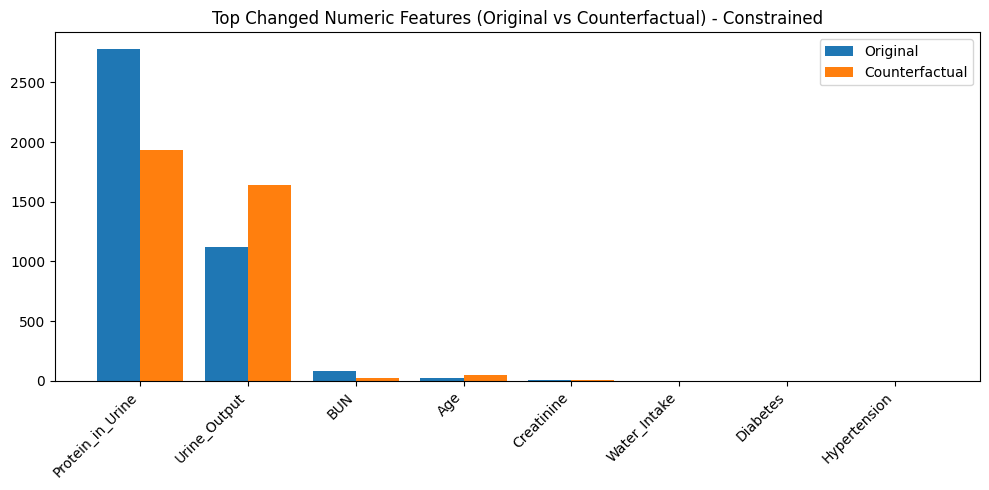

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_label_and_proba(pipeline, X_row_df, threshold=0.5):
    proba = pipeline.predict_proba(X_row_df)[:, 1][0]
    label = int(proba >= threshold)
    return label, proba

def build_feature_bounds(df, numeric_cols, method="p1_p99"):
    bounds = {}
    for c in numeric_cols:
        if method == "minmax":
            lo, hi = float(df[c].min()), float(df[c].max())
        else:
            lo, hi = float(df[c].quantile(0.01)), float(df[c].quantile(0.99))
        if lo == hi:
            lo, hi = float(df[c].min()), float(df[c].max())
        bounds[c] = (lo, hi)
    return bounds

def build_healthy_reference(df, numeric_cols, categorical_cols, medication_preference=None):
    healthy = df[df["CKD_Status"] == 0].copy()
    ref = {}
    for c in numeric_cols:
        ref[c] = float(healthy[c].median())

    for c in categorical_cols:
        if c == "Medication" and medication_preference is not None:
            ref[c] = medication_preference
        else:
            ref[c] = healthy[c].mode().iloc[0] if len(healthy[c].mode()) > 0 else healthy[c].iloc[0]
    return ref

def enforce_constraints(
    x_new,
    x_orig,
    numeric_cols,
    categorical_cols,
    feature_bounds,
    binary_cols=("Diabetes", "Hypertension"),
    integer_cols=("Age",),
    improve_only_cols=None
):

    for c in numeric_cols:
        lo, hi = feature_bounds[c]
        x_new[c] = float(np.clip(float(x_new[c].iloc[0]), lo, hi))

    for b in binary_cols:
        if b in x_new.columns:
            x_new[b] = int(float(x_new[b].iloc[0]) >= 0.5)

    for ic in integer_cols:
        if ic in x_new.columns:
            lo, hi = feature_bounds.get(ic, (None, None))
            val = int(round(float(x_new[ic].iloc[0])))
            if lo is not None and hi is not None:
                val = int(np.clip(val, lo, hi))
            x_new[ic] = val

    if improve_only_cols:
        for c in improve_only_cols:
            if c in x_new.columns:
                orig = float(x_orig[c].iloc[0])
                newv = float(x_new[c].iloc[0])
                if newv > orig:
                    x_new[c] = orig

    return x_new

def generate_counterfactual_guided_constrained(
    pipeline,
    x0,
    numeric_cols,
    categorical_cols,
    feature_bounds,
    healthy_ref,
    desired_label=0,
    max_iters=50000,
    step_scale=0.22,
    alpha=0.12,
    top_k_numeric=8,
    n_restarts=6,
    random_state=42,
    threshold=0.5,
    binary_cols=("Diabetes", "Hypertension"),
    integer_cols=("Age",),
    improve_only_cols=("Creatinine", "BUN", "Protein_in_Urine")
):
    rng = np.random.default_rng(random_state)
    x0 = x0.copy()

    label0, proba0 = predict_label_and_proba(pipeline, x0, threshold=threshold)
    if label0 == desired_label:
        return x0, {"iters": 0, "orig_label": label0, "orig_proba": proba0, "cf_proba": proba0}

    candidate_nums = list(numeric_cols)
    if "imp_df" in globals():
        ordered = [f for f in imp_df["feature"].tolist() if f in numeric_cols]
        candidate_nums = ordered[:top_k_numeric] if len(ordered) >= top_k_numeric else ordered
    else:
        candidate_nums = candidate_nums[:top_k_numeric]

    candidate_nums = [c for c in candidate_nums if c not in binary_cols]

    cats_dict = {c: list(df[c].unique()) for c in categorical_cols}

    def dist(xa, xb):
        d = 0.0
        for c in numeric_cols:
            a = float(xa[c].iloc[0]); b = float(xb[c].iloc[0])
            lo, hi = feature_bounds[c]
            rngv = max(hi - lo, 1e-9)
            d += abs(a - b) / rngv
        for c in categorical_cols:
            d += 0.15 if xa[c].iloc[0] != xb[c].iloc[0] else 0.0
        return d

    best_cf, best_dist, best_meta = None, np.inf, None

    for r in range(n_restarts):
        x_try = x0.copy()

        for it in range(1, max_iters + 1):
            x_new = x_try.copy()

            for c in candidate_nums:
                if c in x_new.columns:
                    lo, hi = feature_bounds[c]
                    cur = float(x_new[c].iloc[0])
                    ref = float(healthy_ref[c])
                    moved = cur + alpha * (ref - cur)
                    x_new[c] = np.clip(moved, lo, hi)

            for c in candidate_nums:
                if c in x_new.columns:
                    lo, hi = feature_bounds[c]
                    rnge = (hi - lo) if (hi - lo) > 0 else 1.0
                    cur = float(x_new[c].iloc[0])
                    noise = rng.normal(0, step_scale) * rnge
                    x_new[c] = np.clip(cur + noise, lo, hi)

            for c in categorical_cols:
                if rng.random() < 0.03:
                    x_new[c] = rng.choice(cats_dict[c])

            x_new = enforce_constraints(
                x_new=x_new,
                x_orig=x0,
                numeric_cols=numeric_cols,
                categorical_cols=categorical_cols,
                feature_bounds=feature_bounds,
                binary_cols=binary_cols,
                integer_cols=integer_cols,
                improve_only_cols=improve_only_cols
            )

            lab, proba = predict_label_and_proba(pipeline, x_new, threshold=threshold)
            x_try = x_new

            if lab == desired_label:
                d = dist(x0, x_new)
                if d < best_dist:
                    best_cf, best_dist = x_new, d
                    best_meta = {
                        "restart": r,
                        "iters": it,
                        "orig_label": label0,
                        "orig_proba": proba0,
                        "cf_proba": proba
                    }
                break

    return best_cf, best_meta

feature_bounds = build_feature_bounds(df, numeric_cols, method="p1_p99")
healthy_ref = build_healthy_reference(df, numeric_cols, categorical_cols, medication_preference=None)

preds = model.predict(X_test)
ckd_idx = X_test.index[preds == 1]
idx = ckd_idx[0] if len(ckd_idx) > 0 else X_test.index[0]

x_instance = X_test.loc[[idx]]
orig_label, orig_proba = predict_label_and_proba(model, x_instance)

print("\n=== Counterfactual Target Instance ===")
print("Index:", idx)
print("Original predicted label (1=CKD):", orig_label, "| CKD probability:", round(float(orig_proba), 4))
print("\nOriginal instance:\n", x_instance)

cf, meta = generate_counterfactual_guided_constrained(
    pipeline=model,
    x0=x_instance,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    feature_bounds=feature_bounds,
    healthy_ref=healthy_ref,
    desired_label=0,
    max_iters=60000,
    step_scale=0.22,
    alpha=0.12,
    top_k_numeric=8,
    n_restarts=8,
    random_state=RANDOM_STATE,
    binary_cols=("Diabetes", "Hypertension"),
    integer_cols=("Age",),
    improve_only_cols=("Creatinine", "BUN", "Protein_in_Urine")  # set None to disable
)

if cf is None:
    print("\nNo counterfactual found under constraints. Try: set improve_only_cols=None or increase max_iters/n_restarts.")
else:
    cf_label, cf_proba = predict_label_and_proba(model, cf)
    print("\n=== Counterfactual Found (Constrained) ===")
    print("Meta:", meta)
    print("Counterfactual predicted label:", cf_label, "| CKD probability:", round(float(cf_proba), 4))

    compare = pd.concat(
        [x_instance.reset_index(drop=True).add_prefix("Original_"),
         cf.reset_index(drop=True).add_prefix("CF_")],
        axis=1
    )
    print("\nOriginal vs Counterfactual:\n", compare)

    diffs = []
    for c in numeric_cols:
        a = float(x_instance[c].iloc[0])
        b = float(cf[c].iloc[0])
        diffs.append((c, abs(a - b), a, b))
    diffs = sorted(diffs, key=lambda x: x[1], reverse=True)[:8]

    plt.figure(figsize=(10, 5))
    labels = [d[0] for d in diffs]
    orig_vals = [d[2] for d in diffs]
    cf_vals = [d[3] for d in diffs]

    x = np.arange(len(labels))
    plt.bar(x - 0.2, orig_vals, width=0.4, label="Original")
    plt.bar(x + 0.2, cf_vals, width=0.4, label="Counterfactual")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.title("Top Changed Numeric Features (Original vs Counterfactual) - Constrained")
    plt.tight_layout()
    plt.legend()
    plt.show()


Streamlit UI

In [4]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.6 MB/s eta 0:00:00


In [7]:
!pip install dice-ml shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.6 MB/s eta 0:00:00


In [15]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import shap
import dice_ml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP & MODEL TRAINING
# ==========================================
@st.cache_resource
def load_data_and_model():
    try:
        df = pd.read_csv("kidney_dataset.csv")
    except:
        # Dummy data fallback
        np.random.seed(42)
        data = {
            'Creatinine': np.random.uniform(0.5, 5.0, 100),
            'BUN': np.random.uniform(10, 50, 100),
            'Urine_Output': np.random.uniform(500, 3000, 100),
            'Age': np.random.randint(20, 90, 100),
            'Protein_in_Urine': np.random.uniform(0, 5, 100),
            'Water_Intake': np.random.uniform(1, 4, 100),
            'Diabetes': np.random.choice([0, 1], 100),
            'Hypertension': np.random.choice([0, 1], 100),
            'Medication': np.random.choice(['None', 'ACE', 'Diuretic'], 100),
            'CKD_Status': np.random.choice([0, 1], 100)
        }
        df = pd.DataFrame(data)

    target = "CKD_Status"
    cols_to_drop = [target]
    if "GFR" in df.columns: cols_to_drop.append("GFR")

    X = df.drop(columns=cols_to_drop, errors='ignore')
    y = df[target]

    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    return model, X_train, df

model_pipeline, X_train, df_full = load_data_and_model()

# ==========================================
# 2. ROBUST EXPLANATION FUNCTIONS
# ==========================================
def generate_shap_explanation(model, X_train, instance):
    try:
        preprocessor = model.named_steps['preprocessor']
        classifier = model.named_steps['classifier']

        X_train_trans = preprocessor.transform(X_train)
        instance_trans = preprocessor.transform(instance)

        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(instance_trans)

        # Robust handling of SHAP output shapes
        if isinstance(shap_values, list):
            vals = shap_values[1] # Class 1
        else:
            vals = shap_values

        # Flatten strictly to 1D
        vals = np.array(vals).flatten()

        # Get feature names
        num_names = preprocessor.named_transformers_['num'].get_feature_names_out().tolist()
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
        feature_names = num_names + cat_names

        # SAFETY CHECK: If lengths don't match, trim or pad to avoid crash
        min_len = min(len(vals), len(feature_names))
        vals = vals[:min_len]
        feature_names = feature_names[:min_len]

        feature_importance = pd.DataFrame({'col_name': feature_names, 'feature_importance_vals': vals})
        feature_importance['abs_val'] = feature_importance['feature_importance_vals'].abs()
        feature_importance = feature_importance.sort_values(by='abs_val', ascending=False).head(3)

        text = "Based on the analysis, the **top 3 factors** driving this prediction are:\n"
        for _, row in feature_importance.iterrows():
            impact_type = "Increasing Risk 🔺" if row['feature_importance_vals'] > 0 else "Lowering Risk 🔻"
            text += f"- **{row['col_name']}**: {impact_type}\n"
        return text, feature_importance

    except Exception as e:
        # Return error message instead of crashing
        return f"Could not generate SHAP graph due to data shape mismatch. (Debug: {str(e)})", None

def generate_dice_counterfactual(model, df_full, instance):
    try:
        target = "CKD_Status"
        d = dice_ml.Data(dataframe=df_full, continuous_features=df_full.select_dtypes('number').columns.drop(target, errors='ignore').tolist(), outcome_name=target)
        m = dice_ml.Model(model=model, backend="sklearn")
        exp = dice_ml.Dice(d, m, method="random")

        e1 = exp.generate_counterfactuals(instance, total_CFs=1, desired_class=0)
        cf_df = e1.cf_examples_list[0].final_cfs_df
        return "To reduce risk, consider aiming for these values:", cf_df
    except Exception as e:
        return f"No simple changes found. (Debug: {str(e)})", None

# ==========================================
# 3. UI LAYOUT
# ==========================================
st.set_page_config(layout="wide")
st.title("🩺 Medical AI Assistant")

# --- SIDEBAR INPUTS ---
# We force the sidebar open by putting important inputs there
with st.sidebar:
    st.header("1. Enter Patient Vitals")
    st.info("👈 Use these sliders to define the patient.")

    creatinine = st.slider('Creatinine', 0.0, 10.0, 1.2)
    bun = st.slider('BUN', 0.0, 100.0, 20.0)
    urine = st.slider('Urine Output', 0.0, 3000.0, 1500.0)
    age = st.slider('Age', 18, 90, 50)
    protein = st.slider('Protein in Urine', 0.0, 5.0, 0.0)
    water = st.slider('Water Intake', 0.0, 5.0, 2.0)
    diab = st.selectbox('Diabetes', [0, 1])
    hyper = st.selectbox('Hypertension', [0, 1])
    meds = st.selectbox('Medication', ['None', 'ACE', 'Diuretic'])

input_df = pd.DataFrame([{
    'Creatinine': creatinine, 'BUN': bun, 'Urine_Output': urine,
    'Diabetes': diab, 'Hypertension': hyper, 'Age': age,
    'Protein_in_Urine': protein, 'Water_Intake': water, 'Medication': meds
}])

# --- MAIN AREA ---
col1, col2 = st.columns([1, 2])

with col1:
    st.subheader("Patient Profile")
    st.dataframe(input_df.astype(str).T, use_container_width=True)

with col2:
    st.subheader("2. Diagnosis & Explainability")

    if st.button("Run Diagnostics", type="primary"):
        pred = model_pipeline.predict(input_df)[0]
        prob = model_pipeline.predict_proba(input_df)[0][1]

        if pred == 1:
            st.error(f"⚠️ **High Risk of CKD** (Confidence: {prob:.1%})")
        else:
            st.success(f"✅ **Low Risk of CKD**")

        st.divider()
        st.markdown("### 💬 Ask the AI Doctor")
        st.write("Examples: *'Why is the risk high?'* or *'How can I lower the risk?'*")

        user_q = st.text_input("Type your question here:")

        if user_q:
            q = user_q.lower()
            if any(x in q for x in ["why", "reason", "cause", "factor"]):
                st.markdown("#### 🔍 Root Cause (SHAP)")
                txt, sdf = generate_shap_explanation(model_pipeline, X_train, input_df)
                st.write(txt)
                if sdf is not None:
                    st.bar_chart(sdf.set_index('col_name')['feature_importance_vals'])

            elif any(x in q for x in ["change", "what if", "how to", "reduce"]):
                st.markdown("#### 🔮 Recommendation (DiCE)")
                txt, cdf = generate_dice_counterfactual(model_pipeline, df_full, input_df)
                st.write(txt)
                if cdf is not None:
                    st.dataframe(cdf)
            else:
                st.info("I didn't understand. Please ask about 'causes' or 'changes'.")

Overwriting app.py


In [16]:
import os
import signal
import subprocess
import time

# 1. Kill old processes
try:
    pids = !pgrep streamlit
    for pid in pids:
        os.kill(int(pid), signal.SIGKILL)
except:
    pass

# 2. Start new process
print("Starting Streamlit...")
process = subprocess.Popen(["streamlit", "run", "app.py"])
!npm install -g localtunnel
time.sleep(5)

# 3. Get the URL
print("\nClick the link below:")
!npx localtunnel --port 8501

Starting Streamlit...
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
changed 22 packages in 4s
⠏
⠏3 packages are looking for funding
⠏  run `npm fund` for details
⠏
Click the link below:
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://short-melons-dress.loca.lt
^C


In [13]:
!curl ipv4.icanhazip.com

34.169.42.182
